# Evaluation the performance of our algorithms

### Load the data

In [1]:
import os
import sys
import pickle
import networkx as nx
import matplotlib as mpl

from pprint import pprint

# Add the project root directory to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.evaluation import graph_scoring
from src.processing import graph_construction

/Users/lukasalemu/Downloads/ls/envs/dissertation_rag/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Select the runs you want to load
for experiment in sorted(os.listdir('../results')):
    print('Experiment:', experiment)
    for run in sorted(os.listdir('../results/' + experiment)):
        print("     || Run:", run)

Experiment: v0
     || Run: 2024-05-10
Experiment: v1
     || Run: 2024-05-10
Experiment: v3
     || Run: 2024-05-10
Experiment: v4
     || Run: 2024-05-10


In [3]:
run_path = 'v4/2024-05-10'

In [4]:
data = {}
# Read the data for the specified experiment
for item in os.listdir('../results/' + run_path):
    print('Loading item:', item.split('.')[0])
    
    with open('../results/' + run_path + '/' + item, 'rb') as f:
        data[item.split('.')[0]] = pickle.load(f)

Loading item: embedded_index
Loading item: adj_matrix


### Evaluate our selected data

In [7]:
# Construct the graph
graph = graph_construction.construct_graph_from_adj_dict(
    adj_dict=data['adj_matrix'],
    edge_thresh=0.9, # -> Needs hyperparameter tuning
    embedded_index=data['embedded_index'],
)

graph_scoring.quick_stats(graph)

Calculating quick stats


{'number_of_nodes': 197,
 'number_of_edges': 19306,
 'average_degree': 196.0,
 'density': 1.0,
 'clustering_coefficient': 1.0}

Aiming for:

- average degree of 20-30
- density of 0.17

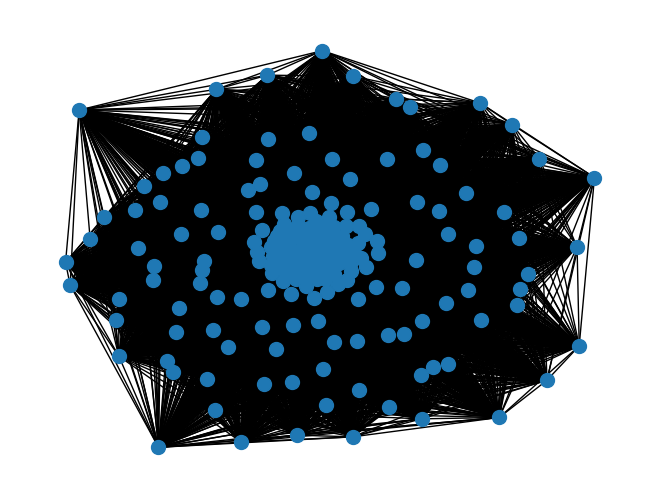

In [8]:
# Visualise the generated graph
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100)

In [67]:
# Evaluate the graph
graph_eval = graph_scoring.evaluate_graph(graph)

# View the results without the communities (as its long)
{k: v for k, v in graph_eval.items() if k != 'communities'}

Calculating simple stats
Calculating attribute stats
Calculating community detection
Calculating node classification


ValueError: row, column, and data arrays must be 1-D

In [ ]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in data['embedded_index']:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

colors = []
for n in graph.nodes:
    for doc in data['embedded_index']:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')
                
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=colors)

In [ ]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=color_map)

In [ ]:
try:
    graph_eval['communities']

    community_node_list = graph_eval['communities']

    # Split viridis into n colors
    n = len(community_node_list)
    viridis = mpl.colormaps['viridis']
    colors = [viridis(i/n) for i in range(n)]

    # Create a dictionary that maps each community to a color
    community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

    node_colors = []

    for node in graph.nodes:
        # Find which community the node belongs to
        for community, color in community_color_dict.items():
            if node in community:
                node_colors.append(color)

    # Draw the graph with the communities colored
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, pos, node_size=100, node_color=node_colors)

    # Print the modularity of the partition
    print("The modularity of this method is:", graph_eval['community_modularity'])

    # Do some evaluation for each of the communities detected.
    for com_nodes in community_node_list:
        subgraph = graph.subgraph(com_nodes)
        subgraph_eval = graph_scoring.simple_stats(subgraph)
        subgraph_eval2 = graph_scoring.attribute_stats(subgraph)
        
        pprint.pprint(subgraph_eval)
        pprint.pprint(subgraph_eval2)
        
        print("-------------------")
        
except KeyError:
    pass